In [1]:
import numpy
from scipy.linalg import solve

In [2]:
def generateMatrix(N, sigma):
    """ Computes the matrix for the diffusion equation with Crank-Nicolson
        Uses Dirichlet condition at i=0, Neumann at i=-1
        
        Parameters:
            N - number of discretization points
            sigma - alpha*dt/dx^2
            
        Returns:
            A - Matrix for diffusion equation        
        """
    
    #Setup diagonal
    d = 2*numpy.diag(numpy.ones(N-2)*(1+1./sigma))
    
    #Consider Neumann BC
    d[-1, -1] = 1+2./sigma
    
    #upper diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    
    #lower diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    
    A = d+ud+ld
    return A

In [10]:
def generateRHS(T, sigma):
    """Computes RHS of linear system for diffusion equation with 
        backward Euler
        
        Parameters:
            T - temp at current time step
            sigma - alpha*dt/dx^2
        
        Return:
            b - RHS of diffusion equation
        """
    
    b = T[1:-1]*2*(1./sigma-1) + T[:-2] + T[2:]
    #Dirichlet BC
    b[0] +=T[0]
    
    return b

In [11]:
def CrankNicolson(T, A, nt, sigma):
    """ Advances diffusion eqn. in time with Crank-Nicolson
    
        Parameters:
            T - initial temp profile
            A - Matrix with discretized diffusion equation
            nt - number of time steps
            sigma - alpha*dt/dx^2
            
        Returns:
            T - temperature profile after nt time steps
        """
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(Tn, sigma)
        T_interior = solve(A, b)
        T[1:-1] = T_interior
        T[-1] = T[-2]
        
    return T

In [24]:
L = 1
nx = 21
alpha = 1.22e-3

dx = L/(nx-1)

Ti = numpy.zeros(nx) 
Ti[0] = 100

sigma = 2
dt = sigma*dx**2/alpha
nt = 10

A = generateMatrix(nx, sigma)

In [25]:
T = CrankNicolson(Ti.copy(), A, nt, sigma)

In [26]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size'] = 16

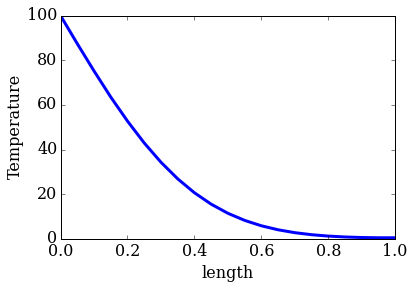

In [27]:
x = numpy.linspace(0, L, nx)
pyplot.plot(x, T, lw=3)
pyplot.xlabel('length')
pyplot.ylabel('Temperature');

In [30]:
from math import pi
def T_analytical(x, t, n_max, alpha, L):
    T = 100
    for n in range(1, n_max+1):
        k = (2*n-1)*pi/(2*L)
        
        summation = 400/((2*n-1)*pi)* numpy.sin(k*x)* numpy.exp(-alpha*k**2*t)
        T -= summation
        
    return T

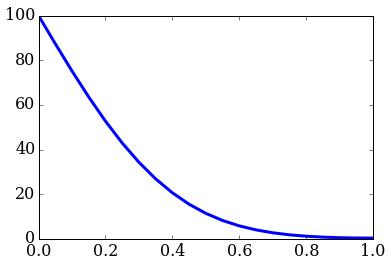

In [32]:
T_exact = T_analytical(x, dt*nt, 100, alpha, L)
pyplot.plot(x, T_exact, lw=3);

In [33]:
T1 = T_analytical(x, .2, 100, alpha, L)
T2 = T_analytical(x, .2, 200, alpha, L)
numpy.sqrt(numpy.sum((T1 - T2)**2)/numpy.sum(T2**2))

6.9279171182600926e-13

In [34]:
def L2_error(T, T_exact):
    """Computes L2 norm of error
    
        Parameters:
            T - array with numerical solution
            T_exact - array with exact solution
            
        Returns: 
            e - L2 norm of error.
        """
    
    e = numpy.sqrt(numpy.sum((T-T_exact)**2)/numpy.sum(T_exact**2))
    
    return e

In [36]:
def generateMatrix_btcs(N, sigma):
    """Computes the matrix for diffusion equation with backward Euler 
        Uses Dirichlet condition at i=0, Neumann at i=-1
        
        """
    #Setup diagonal
    d = numpy.diag(numpy.ones(N-2)*(2+1./sigma))
    
    #Consider Neumann BC
    d[-1, -1] = 1+1./sigma
    
    #Upper diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    
    #Lower Diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    
    A = d + ud + ld
    return A

In [37]:
def generateRHS_btcs(T, sigma):
    b = numpy.zeros_like(T)
    
    b = T[1:-1]*1./sigma
    #Consider Dirichlet BC
    b[0] += T[0]
    
    return b

In [38]:
def implicit_btcs(T, A, nt, sigma):
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS_btcs(Tn, sigma)
        T_interior = solve(A, b)
        T[1:-1] = T_interior
        T[-1] = T[-2]
        
    return T

In [39]:
nx = 1001
dx = L/(nx-1)

dt_values = numpy.asarray([1.0, 0.5, 0.25, 0.125])
error = numpy.zeros(len(dt_values))
error_ftcs = numpy.zeros(len(dt_values))

t_final = 10
t_initial = 1

x = numpy.linspace(0, L, nx)

Ti = T_analytical(x, t_initial, 100, alpha, L)
T_exact = T_analytical(x, t_final, 100, alpha, L)

for i, dt in enumerate(dt_values):
    sigma = alpha*dt/dx**2
    
    nt = int((t_final-t_initial)/dt)
    A = generateMatrix(nx, sigma)
    A_btcs = generateMatrix_btcs(nx, sigma)
    T = CrankNicolson(Ti.copy(), A, nt, sigma)
    error[i] = L2_error(T, T_exact)
    
    T = implicit_btcs(Ti.copy(), A_btcs, nt, sigma)
    error_ftcs[i] = L2_error(T, T_exact)

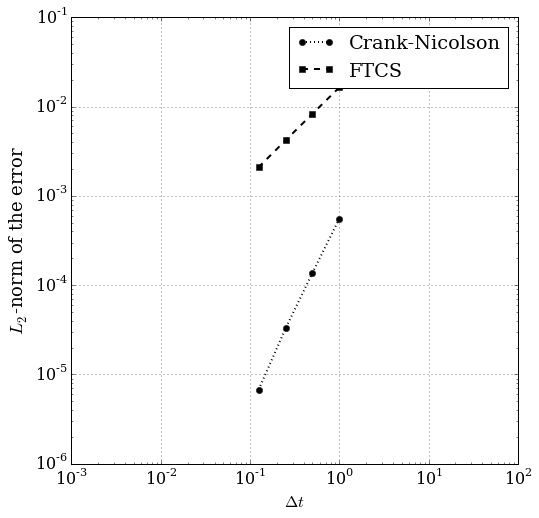

In [43]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$')
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.axis('equal')
pyplot.loglog(dt_values, error,  ls=':', lw=2, marker='o')
pyplot.loglog(dt_values, error_ftcs, ls='--', lw=2, marker='s')
pyplot.legend(['Crank-Nicolson', 'FTCS']);

In [44]:
error

array([  5.56252560e-04,   1.37457564e-04,   3.28517043e-05,
         6.77164747e-06])

In [45]:
nx_values = numpy.asarray([11, 21, 41, 81, 161])

dt = 0.1
error = numpy.zeros(len(nx_values))

t_final = 20
x = numpy.linspace(0, L, nx)

for i, nx in enumerate(nx_values):
    dx = L/(nx-1)
    x = numpy.linspace(0, L, nx)
    
    sigma = alpha*dt/dx**2
    nt = int(t_final/dt)
    A = generateMatrix(nx, sigma)
    
    Ti = numpy.zeros(nx)
    Ti[0] = 100
    
    T = CrankNicolson(Ti.copy(), A, nt, sigma)
    T_exact = T_analytical(x, t_final, 100, alpha, L)
    error[i] = L2_error(T, T_exact)

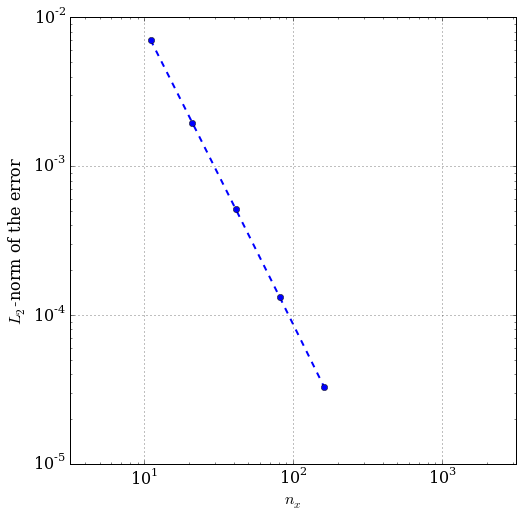

In [46]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$')
pyplot.ylabel(r'$L_2$-norm of the error')
pyplot.axis('equal')
pyplot.loglog(nx_values, error, ls='--', lw=2, marker='o');

In [52]:
nx_values = numpy.asarray([11, 21, 41, 81, 161])

dt = 0.1
error = numpy.zeros(len(nx_values))

t_final = 1000
x = numpy.linspace(0, L, nx)

for i, nx in enumerate(nx_values):
    dx = L/(nx-1)
    x = numpy.linspace(0, L, nx)
    
    sigma = alpha*dt/dx**2
    nt = int(t_final/dt)
    
    A = generateMatrix(nx, sigma)
    Ti = numpy.zeros(nx)
    Ti[0] = 100
    
    T = CrankNicolson(Ti.copy(), A, nt, sigma)
    T_exact = T_analytical(x, t_final, 100, alpha, L)
    error[i] = L2_error(T, T_exact)

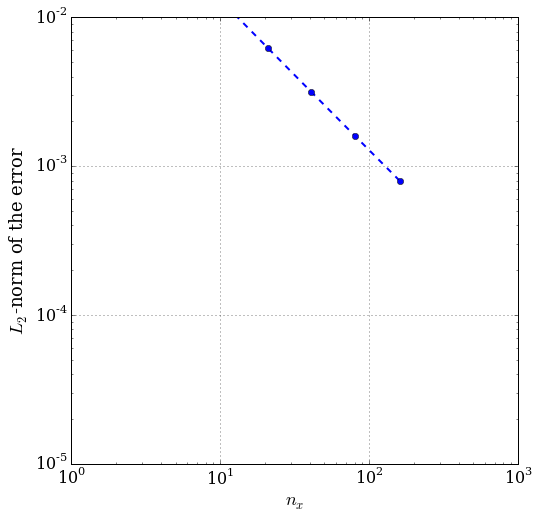

In [53]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.xlim(1, 1000)
pyplot.ylim(1e-5, 1e-2)
pyplot.loglog(nx_values, error, ls='--', lw=2, marker='o');

In [54]:
error

array([ 0.01192272,  0.00618159,  0.00314266,  0.00158386,  0.00079501])